In [1]:
!pip install -q hvplot pyarrow


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [ ]:
from pathlib import Path
import numpy as np, pandas as pd, geopandas as gpd, rioxarray as rxr
import dask, dask.bag as db
from dask.diagnostics import ProgressBar
dask.config.set(scheduler="threads") 

PAD      = Path("./pad")   
KML_DIR  = Path("/Users/iamnoob/Study/Diploma/Final")
MAX_DT   = 60            
OUTL_FR  = 0.02              
EDGE_PAD = 5                           

INDEXES = (
    "NDWI","NDMI","NDVI","SR","REP","EVI","EVI2",
    "ARVI","SAVI","GOSAVI","GARI","VARI"
)
INDEX_RANGES = {                            
    "NDWI":(-1,1),"NDMI":(-1,1),"NDVI":(-1,1),"SR":(0,10),"REP":(680,750),
    "EVI":(-1,3),"EVI2":(-1,3),"ARVI":(-2,2),"SAVI":(-1,1),
    "GOSAVI":(-1,1),"GARI":(-2,2),"VARI":(-2,2),
}

In [ ]:
def season_of(month: int) -> str:
    if month in (5, 6):
        return "spring"           
    if month in (10, 11):
        return "autumn"           
    return "other"          

In [ ]:
rows = []
for pred in PAD.rglob("*_pred_roi.tif"):
    parts = pred.relative_to(PAD).parts    
    if len(parts) < 5 or parts[3] != "pred":
        continue

    field_id, year, bucket = parts[0], parts[1], parts[2]
    date_str  = pred.stem.split("_")[2]       
    month     = int(date_str[5:7])
    season    = season_of(month)
    if season == "other":                   
        continue

    raw_s2 = pred.parents[1] / "s2" / pred.name.replace("_pred_roi", "")

    kml_path = (KML_DIR / f"{field_id}.kml"
                if (KML_DIR / f"{field_id}.kml").exists()
                else KML_DIR / f"{field_id}_256.kml")

    rows.append({
        "field_id":  field_id,
        "year":      int(year),
        "bucket":    int(bucket),
        "date":      date_str,
        "season":    season,
        "pred_path": str(pred),
        "raw_path":  str(raw_s2),
        "kml_path":  str(kml_path),
    })

manifest = (
    pd.DataFrame(rows)
      .drop_duplicates(subset="pred_path") 
      .reset_index(drop=True)
)
print(f"Строк в манифесте: {len(manifest)}")

Строк в манифесте: 5989


In [ ]:
def compute_index(name: str, B):
    """
    B — xarray.DataArray (band, y, x) с заменой nodata→NaN.
    """
    eps = 1e-8
    b = {i: B.sel(band=i) for i in range(13)} 

    if name == "NDWI":
        return (b[2] - b[7]) / (b[2] + b[7] + eps)
    if name == "NDMI":
        return (b[7] - b[11]) / (b[7] + b[11] + eps)
    if name == "NDVI":
        return (b[7] - b[3]) / (b[7] + b[3] + eps)
    if name == "SR":
        return b[7] / (b[3] + eps)
    if name == "REP":
        num = ((b[6] + b[3]) / 2) - b[4]
        den = (b[5] - b[4]) + eps
        return 700 + 40 * (num / den)
    if name == "EVI":
        return 2.5 * (b[7] - b[3]) / (b[7] + 6 * b[3] - 7.5 * b[1] + 1 + eps)
    if name == "EVI2":
        return 2.5 * (b[7] - b[3]) / (b[7] + b[3] + 1 + eps)
    if name == "ARVI":
        return (b[7] - (2 * b[3] - b[1])) / (b[7] + (2 * b[3] - b[1]) + eps)
    if name == "SAVI":
        return 1.5 * (b[7] - b[3]) / (b[7] + b[3] + 0.5 + eps)
    if name == "GOSAVI":
        return (b[7] - b[2]) / (b[7] + b[2] + 0.16 + eps)
    if name == "GARI":
        return (b[7] - (b[2] - (b[1] - b[3]))) / (b[7] + (b[2] - (b[1] - b[3])) + eps)
    if name == "VARI":
        return (b[2] - b[3]) / (b[2] + b[3] - b[1] + eps)

    raise ValueError(f"Unsupported index {name}")

def open_roi(tif_path: str,
             field_geom,
             chunks = {"band": 1, "y": 1024, "x": 1024}):
    """
    Открываем GeoTIFF, обрезаем рамку EDGE_PAD и клипуем по ROI.
    Все nodata → NaN.  Возвращаем xarray.DataArray.
    """
    da = rxr.open_rasterio(tif_path, masked=True, chunks=chunks)
    da = da.assign_coords(band=np.arange(da.sizes["band"]))
    if da.rio.nodata is not None:
        da = da.where(da != da.rio.nodata)

    if EDGE_PAD:
        da = da.isel(x=slice(EDGE_PAD, -EDGE_PAD),
                     y=slice(EDGE_PAD, -EDGE_PAD))

    return da.rio.clip(field_geom, da.rio.crs, drop=True)

In [ ]:
def make_etalon(df: pd.DataFrame) -> pd.DataFrame:
    return (df[df.bucket == 0]
              .sort_values("date")
              .groupby(["field_id", "season"])
              .first()
              .reset_index())

etalon = make_etalon(manifest)
print("Эталонов:", len(etalon))  
etalon.head()

Эталонов: 40


,field_id,season,year,bucket,date,pred_path,raw_path,kml_path
0,0127,autumn,2019,0,2019-10-13,pad/0127/2019/00/pred/S2_0127_2019-10-13_0002_...,pad/0127/2019/00/s2/S2_0127_2019-10-13_0002.tif,/Users/iamnoob/Study/Diploma/Final/0127.kml
1,0127,spring,2019,0,2019-05-16,pad/0127/2019/00/pred/S2_0127_2019-05-16_0004_...,pad/0127/2019/00/s2/S2_0127_2019-05-16_0004.tif,/Users/iamnoob/Study/Diploma/Final/0127.kml
2,0605,autumn,2019,0,2019-10-13,pad/0605/2019/00/pred/S2_0605_2019-10-13_0002_...,pad/0605/2019/00/s2/S2_0605_2019-10-13_0002.tif,/Users/iamnoob/Study/Diploma/Final/0605.kml
3,0605,spring,2019,0,2019-05-16,pad/0605/2019/00/pred/S2_0605_2019-05-16_0004_...,pad/0605/2019/00/s2/S2_0605_2019-05-16_0004.tif,/Users/iamnoob/Study/Diploma/Final/0605.kml
4,0710,autumn,2019,0,2019-10-13,pad/0710/2019/00/pred/S2_0710_2019-10-13_0002_...,pad/0710/2019/00/s2/S2_0710_2019-10-13_0002.tif,/Users/iamnoob/Study/Diploma/Final/0710.kml


In [ ]:
def _as_float(x) -> float:
    try:
        return float(x)
    except Exception:
        pass
    if isinstance(x, (list, tuple)):
        try:
            return float(np.nanmean([_as_float(v) for v in x]))
        except Exception:
            return np.nan
    try:
        arr = np.asarray(x).astype(float)
        return float(np.nanmean(arr))
    except Exception:
        return np.nan

In [ ]:
bad_rows, good_rows = [], []

def analyse(row0):
    field = gpd.read_file(row0["kml_path"], driver="KML").to_crs(
            rxr.open_rasterio(row0["raw_path"]).rio.crs)
    ref_da = open_roi(row0["raw_path"], field.geometry)
    ref_means = {idx: _as_float(compute_index(idx, ref_da).mean(skipna=True))
                 for idx in INDEXES}

    fid, seas = row0["field_id"], row0["season"]
    cloudies = (manifest
                .query("field_id == @fid and season == @seas and bucket > 0")
                .sort_values("bucket"))

    date0 = pd.to_datetime(row0["date"])
    for _, r in cloudies.iterrows():
        dt = (pd.to_datetime(r["date"]) - date0).days
        if not (0 < dt <= MAX_DT):
            continue

        da = open_roi(r["pred_path"], field.geometry)

        extremes, is_bad = {}, False
        for idx in INDEXES:
            arr = compute_index(idx, da)
            lo, hi = INDEX_RANGES[idx]

            mask_bad = (arr < lo) | (arr > hi)
            num_bad  = int(mask_bad.sum().compute())    
            frac_bad = num_bad / mask_bad.size        
            extremes[f"{idx}_frac_bad"] = frac_bad
            if frac_bad > OUTL_FR:
                is_bad = True

        if is_bad:
            bad_rows.append(dict(field_id=r["field_id"], season=r["season"],
                                 bucket=int(r["bucket"]), date=r["date"],
                                 pred_path=r["pred_path"], **extremes))
            continue

        means, deltas, apes = {}, {}, {}
        for idx in INDEXES:
            m = _as_float(compute_index(idx, da).mean(skipna=True))
            means[idx] = m
            ref = ref_means.get(idx, np.nan)
            delta = m - ref if np.isfinite(ref) else np.nan
            ape   = abs(delta / ref) if np.isfinite(ref) and ref else np.nan
            deltas[f"Δ{idx}"] = delta
            apes[f"APE_{idx}"] = ape

        good_rows.append({
            "field_id": r["field_id"],
            "season":   r["season"],
            "bucket":   int(r["bucket"]),
            "dt":       dt,
            "pred_path": r["pred_path"],  
            **means,
            **deltas,
            **apes,
        })

In [ ]:
bag = db.from_sequence(etalon.to_dict("records"), npartitions=16)
with ProgressBar():
    bag.map(analyse).compute()

df_good = pd.DataFrame(good_rows)
df_bad  = pd.DataFrame(bad_rows)
print("Нормальных сравнений:", len(df_good))
print("Плохих сцен (OUTL_FR > 2 %):", len(df_bad))

[########################################] | 100% Completed | 67.08 s
Нормальных сравнений: 196
Плохих сцен (OUTL_FR > 2 %): 171


In [ ]:
df_good = df_good[df_good.bucket.isin([20,30,40,50,60,70])]

def summary_for(idx):
    g = df_good.groupby(["season","bucket"])
    return g.agg(
        mae  =(f"Δ{idx}", lambda s: s.abs().mean()),
        bias =(f"Δ{idx}", "mean"),
        mape =(f"APE_{idx}", "mean"),
        std  =(f"Δ{idx}", "std"),
        iqr  =(f"Δ{idx}", lambda s: s.quantile(0.75) - s.quantile(0.25)),
        n    =(f"Δ{idx}", "count")
    )

summary = pd.concat({idx: summary_for(idx) for idx in INDEXES}, axis=1)

In [ ]:
print("=== SPRING (май–июнь) ===")
display(summary.loc["spring"])

print("\n=== AUTUMN (октябрь–ноябрь) ===")
display(summary.loc["autumn"])

=== SPRING (май–июнь) ===


NDWI                                                  NDMI  \
             mae      bias      mape       std       iqr   n       mae   
bucket                                                                   
20      0.166753  0.008555  0.577619  0.199662  0.334584  30  0.242956   
30      0.167698 -0.047300  0.724847  0.210626  0.067506   7  0.228038   
40      0.122654 -0.002372  0.409001  0.171021  0.021051   9  0.219856   
50      0.141552  0.034297  0.401772  0.190062  0.195581  30  0.225211   
60      0.105759  0.053147  0.228151  0.132981  0.195724   7  0.172275   
70      0.138324 -0.027948  0.589090  0.169968  0.085725  11  0.209687   

                                      ...      GARI                          \
            bias      mape       std  ...      mape       std       iqr   n   
bucket                                ...                                     
20      0.008912  0.807532  0.288596  ...  0.306044  0.222091  0.258967  30   
30      0.048494  0.759806  0.300578  ...  0.303983  0.271068  0.109352   7   
40      0.022141  0.741674  0.291243  ...  0.420034  0.235171  0.104979   9   
50     -0.018981  0.715787  0.283534  ...  0.326102  0.228597  0.197692  30   
60     -0.006305  0.520471  0.199383  ...  0.313132  0.188055  0.218655   7   
70      0.035781  0.714199  0.258660  ...  0.243596  0.184089  0.110924  11   

            VARI                                              
             mae      bias      mape       std       iqr   n  
bucket                                                        
20      0.415364 -0.385632  1.231452  0.437822  0.604144  30  
30      0.310814 -0.285878  1.355532  0.410951  0.203816   7  
40      0.372645 -0.286117  1.675952  0.402320  0.214241   9  
50      0.348348 -0.264862  0.996096  0.430752  0.429507  30  
60      0.364835 -0.313045  0.896560  0.394029  0.614311   7  
70      0.336762 -0.322170  1.531302  0.332404  0.209286  11  

[6 rows x 72 columns]


=== AUTUMN (октябрь–ноябрь) ===


NDWI                                                  NDMI  \
             mae      bias      mape       std       iqr   n       mae   
bucket                                                                   
20      0.138101 -0.131927  2.643785  0.098421  0.156190  21  0.097811   
30      0.154832 -0.146490  2.698893  0.103688  0.099802   5  0.140449   
40      0.179941 -0.141407  3.917107  0.152263  0.162221   5  0.179733   
60      0.149096 -0.149096  2.271094  0.065214  0.063081   3  0.134383   

                                      ...      GARI                          \
            bias      mape       std  ...      mape       std       iqr   n   
bucket                                ...                                     
20      0.056761  0.517066  0.112571  ...  0.308297  0.122028  0.154537  21   
30      0.087170  0.778316  0.136580  ...  0.327484  0.148299  0.189771   5   
40      0.111961  0.708212  0.173342  ...  0.382995  0.149790  0.193450   5   
60      0.134383  0.512497  0.111070  ...  0.290627  0.087818  0.085018   3   

            VARI                                              
             mae      bias      mape       std       iqr   n  
bucket                                                        
20      0.227091 -0.202399  1.328993  0.199380  0.237779  21  
30      0.265703 -0.265703  1.325100  0.224285  0.392748   5  
40      0.220200 -0.204412  1.523039  0.201780  0.093769   5  
60      0.291134 -0.291134  1.565777  0.155038  0.151140   3  

[4 rows x 72 columns]

Поле 0710  |  эталон: 2019-05-16  (bucket 0 %)


,type,date,bucket,min,mean,max
0,RAW-0%,2019-05-16,0,0.171,0.293,0.807
1,PRED,2019-05-26,50,-0.004,0.298,0.690
2,PRED,2019-06-05,50,0.336,0.690,0.811
3,PRED,2019-06-10,20,0.274,0.616,0.773


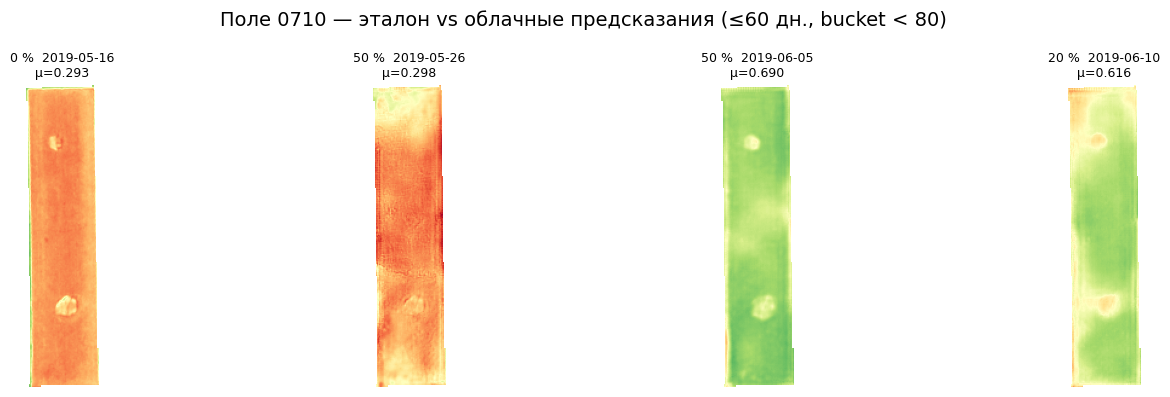

In [ ]:
import random, matplotlib.pyplot as plt, pandas as pd

row0   = etalon.sample(1).iloc[0]
field  = row0["field_id"]
date0  = pd.to_datetime(row0["date"])
print(f"Поле {field}  |  эталон: {row0['date']}  (bucket 0 %)")

da0    = rxr.open_rasterio(row0["raw_path"], masked=True).assign_coords(band=np.arange(13))
poly   = gpd.read_file(row0["kml_path"], driver="KML").to_crs(da0.rio.crs)
clip0  = da0.rio.clip(poly.geometry, da0.rio.crs, drop=True)
ndvi0  = compute_index("NDVI", clip0)
stats  = [{
    "type":   "RAW-0%",
    "date":   row0["date"],
    "bucket": 0,
    "min":    float(ndvi0.min()),
    "mean":   float(ndvi0.mean()),
    "max":    float(ndvi0.max())
}]

cloudies = manifest[(manifest["field_id"] == field) & (manifest["bucket"] > 0)]
cloudies = cloudies[
    (cloudies["bucket"] < 80) &
    (cloudies["date"].apply(lambda d: 0 < (pd.to_datetime(d) - date0).days <= MAX_DT))
].copy()
cloudies["date_dt"] = pd.to_datetime(cloudies["date"])
cloudies = cloudies.sort_values("date_dt").reset_index(drop=True)

ncols = 1 + len(cloudies)
fig, axes = plt.subplots(1, ncols, figsize=(4*ncols, 4), sharex=True, sharey=True)

def imshow(ax, ndvi_da, title):
    im = ax.imshow(ndvi_da, cmap="RdYlGn", vmin=0, vmax=1)
    ax.set_title(title, fontsize=9)
    ax.axis('off')
    return im

imshow(axes[0], ndvi0, f"0 %  {row0['date']}\nμ={stats[0]['mean']:.3f}")

for ax, (_, r) in zip(axes[1:], cloudies.iterrows()):
    da   = rxr.open_rasterio(r["pred_path"], masked=True).assign_coords(band=np.arange(13))
    clip = da.rio.clip(poly.geometry, da.rio.crs, drop=True)
    ndvi = compute_index("NDVI", clip)
    stats.append({
        "type":   "PRED",
        "date":   r["date"],
        "bucket": int(r["bucket"]),
        "min":    float(ndvi.min()),
        "mean":   float(ndvi.mean()),
        "max":    float(ndvi.max())
    })
    imshow(
        ax,
        ndvi,
        f"{r['bucket']} %  {r['date']}\nμ={stats[-1]['mean']:.3f}"
    )

fig.suptitle(
    f"Поле {field} — эталон vs облачные предсказания (≤{MAX_DT} дн., bucket < 80)",
    fontsize=14
)
plt.tight_layout()

df_stats = pd.DataFrame(stats)
df_stats = df_stats[df_stats["bucket"] < 80].sort_values("date").reset_index(drop=True)
display(
    df_stats.style.format({
        "min": "{:.3f}",
        "mean": "{:.3f}",
        "max": "{:.3f}"
    })
)

Поле 1603  |  сезон spring  |  эталон 2019-05-16


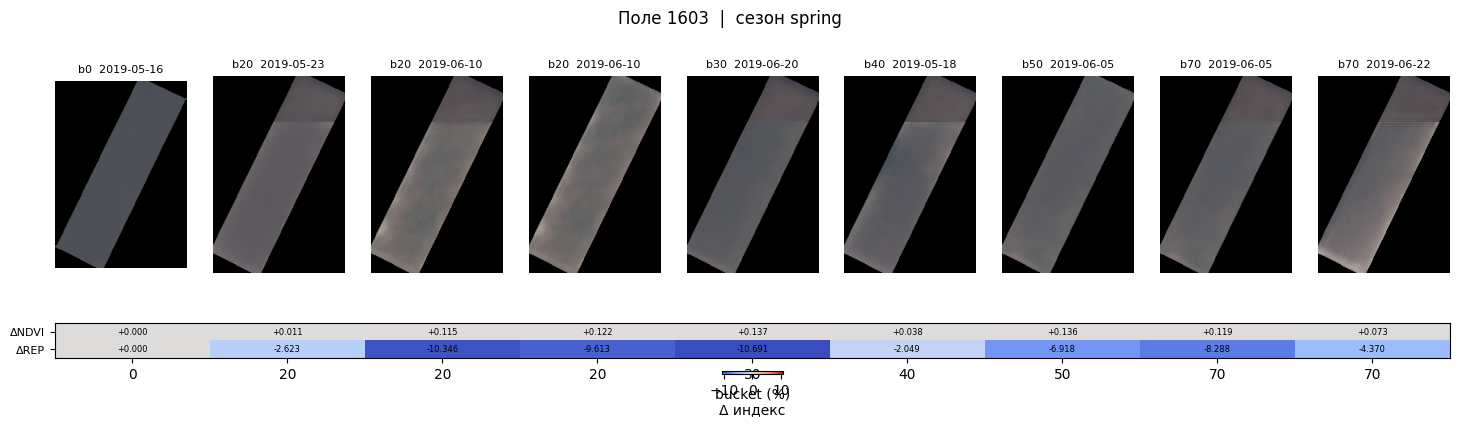

,bucket,date,path,NDVI,REP,ΔNDVI,ΔREP
0,0,2019-05-16,pad/1603/2019/00/s2/S2_1603_2019-05-16_0013.tif,0.147,731.9,0.000,0.000
1,20,2019-05-23,pad/1603/2019/20/pred/S2_1603_2019-05-23_0020_...,0.158,729.3,0.011,-2.623
2,20,2019-06-10,pad/1603/2019/20/pred/S2_1603_2019-06-10_0034_...,0.261,721.6,0.115,-10.346
3,20,2019-06-10,pad/1603/2019/20/pred/S2_1603_2019-06-10_0033_...,0.268,722.3,0.122,-9.613
4,30,2019-06-20,pad/1603/2019/30/pred/S2_1603_2019-06-20_0040_...,0.283,721.2,0.137,-10.691
5,40,2019-05-18,pad/1603/2019/40/pred/S2_1603_2019-05-18_0016_...,0.184,729.9,0.038,-2.049
6,50,2019-06-05,pad/1603/2019/50/pred/S2_1603_2019-06-05_0029_...,0.283,725.0,0.136,-6.918
7,70,2019-06-05,pad/1603/2019/70/pred/S2_1603_2019-06-05_0030_...,0.266,723.6,0.119,-8.288
8,70,2019-06-22,pad/1603/2019/70/pred/S2_1603_2019-06-22_0042_...,0.220,727.6,0.073,-4.370


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import numpy as np, pandas as pd, geopandas as gpd, rioxarray as rxr
from IPython.display import display
import random
from typing import Optional

def _plot_rgb(ax, da, title: str, gamma: float = 0.45):
    """
    Отображает кадр без гистограммных растяжек.
    • если макс-знач > 1.5 → делим на 10000 (Sentinel-2 uint16)
    • NaN → 0 — чтобы «дырки» не давали прозрачность
    • γ-коррекция (~0.45) только для визуального высветления
    """
    r = da.sel(band=3).values.astype("float32")
    g = da.sel(band=2).values.astype("float32")
    b = da.sel(band=1).values.astype("float32")
    rgb = np.stack([r, g, b])                    # (3, H, W)

    if np.nanmax(rgb) > 1.5:                 
        rgb /= 10000.0

    rgb = np.nan_to_num(rgb, nan=0.0)            # заполнили дырки чёрным
    rgb = np.clip(rgb, 0, 1) ** gamma        
    ax.imshow(rgb.transpose(1, 2, 0))
    ax.axis("off")
    ax.set_title(title, fontsize=8)

def visualize_random_etalon(seed: Optional[int] = None):
    """
    • Случайный эталон (bucket 0) и все «хорошие» последователи
    • Первая строка — RGB-кадры
    • Вторая строка — теплокарта ΔNDVI / ΔREP
    • Отдельно выводится DataFrame с bucket, датой, путём файла и индексами
    """
    if seed is not None:
        random.seed(seed); np.random.seed(seed)

    row0 = etalon.sample(1).iloc[0]
    fid, seas = row0.field_id, row0.season
    print(f"Поле {fid}  |  сезон {seas}  |  эталон {row0.date}")

    followers = (df_good[(df_good.field_id == fid) &
                         (df_good.season   == seas)]
                 .sort_values("bucket"))

    scenes = [dict(bucket=0, path=row0.raw_path, date=row0.date)] + [
        dict(bucket=int(r.bucket),
             path=r.pred_path,
             date=(pd.to_datetime(row0.date) + pd.Timedelta(r["dt"], "D")
                   ).strftime("%Y-%m-%d"))
        for _, r in followers.iterrows()
    ]

    geom = gpd.read_file(row0.kml_path, driver="KML")\
             .to_crs(rxr.open_rasterio(row0.raw_path).rio.crs).geometry
    for sc in scenes:
        da = open_roi(sc["path"], geom);  sc["da"] = da
        for idx in INDEXES:
            sc[idx] = float(compute_index(idx, da).mean(skipna=True).compute())

    ref_ndvi, ref_rep = scenes[0]["NDVI"], scenes[0]["REP"]
    for sc in scenes:
        sc["dNDVI"] = sc["NDVI"] - ref_ndvi
        sc["dREP"]  = sc["REP"]  - ref_rep

    n = len(scenes)
    fig = plt.figure(figsize=(min(3*n, 18), 4.0))
    gs  = GridSpec(2, n, height_ratios=[3, .7], hspace=0.30)

    for j, sc in enumerate(scenes):
        _plot_rgb(fig.add_subplot(gs[0, j]),
                  sc["da"],
                  f"b{sc['bucket']}  {sc['date']}")

    axh  = fig.add_subplot(gs[1, :])
    data = np.vstack([[sc["dNDVI"] for sc in scenes],
                      [sc["dREP"]  for sc in scenes]])
    im = axh.imshow(data, aspect="auto", cmap="coolwarm",
                    norm=mcolors.CenteredNorm())
    axh.set_xticks(range(n))
    axh.set_xticklabels([sc["bucket"] for sc in scenes])
    axh.set_yticks([0, 1])
    axh.set_yticklabels(["ΔNDVI", "ΔREP"], fontsize=8)
    for i in range(2):
        for j in range(n):
            axh.text(j, i, f"{data[i, j]:+.3f}", ha="center", va="center",
                     fontsize=6)
    axh.set_xlabel("bucket (%)")
    plt.colorbar(im, ax=axh, orientation="horizontal",
                 fraction=0.06, pad=0.25, label="Δ индекс")
    plt.suptitle(f"Поле {fid}  |  сезон {seas}", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()

    table = pd.DataFrame({
        "bucket":   [sc["bucket"] for sc in scenes],
        "date":     [sc["date"]   for sc in scenes],
        "path":     [sc["path"]   for sc in scenes],
        "NDVI":     [round(sc["NDVI"], 3) for sc in scenes],
        "REP":      [round(sc["REP"],  1) for sc in scenes],
        "ΔNDVI":    [round(sc["dNDVI"], 3) for sc in scenes],
        "ΔREP":     [round(sc["dREP"],  3) for sc in scenes],
    })
    display(table)

visualize_random_etalon()
